In [267]:
#Importar las librerías por utilizar
import os
import numpy as np
from skimage import io, color
from skimage.filters import median
from skimage.transform import resize, probabilistic_hough_line,hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import cm

#Obtener la direccion de las imagenes
path = os.getcwd()

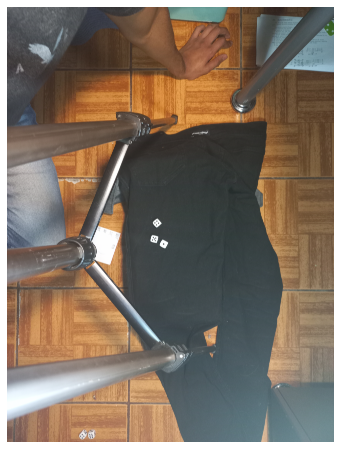

tamaño: (9248, 6936, 3)


In [268]:
#Imagen original
file_path = os.path.join(path , 'IMG_09.jpg')
img_org = io.imread(file_path)
shape = img_org.shape

plt.figure(figsize = (6,8))
plt.imshow(img_org)
plt.axis('off')
plt.show()
print('tamaño: ' + str(img_org.shape))

In [269]:
#PARAMETROS

#Tamaño de trabajo
SIZE=(1544,1158)

#numero de colores incluyendo el fondo
N_COLORS = 2

MAX_RHO = 18
MAX_THETA = 5*np.pi/180

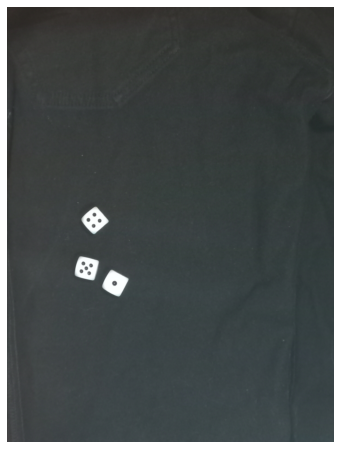

tamaño: (1544, 1158, 3)


In [270]:
def edit_image(image):
    y,x = image.shape[:2]
    y_div = y//3
    x_div = x//3
    x_off = 250
    cropped = image[y_div:2*y_div,x_div+x_off:2*x_div+x_off]
    resized = resize(cropped,(SIZE[0],SIZE[1]),preserve_range=True).astype(int)
    return resized

img_edit = edit_image(img_org)
plt.figure(figsize = (6,8))
plt.imshow(img_edit)
plt.axis('off')
plt.show()
print('tamaño: ' + str(img_edit.shape))

[[ 57  63  63]
 [243 247 247]]


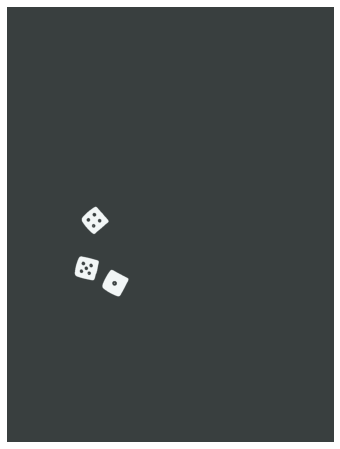

In [271]:
#Quantificacion 2 colores
#https://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html#sphx-glr-auto-examples-cluster-plot-color-quantization-py

def img_to_2_colors(img):
    # Copia de la imagen por cuantificar
    img_5_colors = img

    # Convert to floats instead of the default 8 bits integer coding. Dividing by
    # 255 is important so that plt.imshow behaves works well on float data (need to
    # be in the range [0-1])
    img_5_colors = np.array(img_5_colors, dtype=np.float64) / 255

    # Load Image and transform to a 2D numpy array.
    w, h, d = original_shape = tuple(img_5_colors.shape)
    assert d == 3
    image_array = np.reshape(img_5_colors, (w * h, d))
    image_array_sample = shuffle(image_array, random_state=0, n_samples=1_000)
    kmeans = KMeans(n_clusters=N_COLORS, random_state=0).fit(image_array_sample)
    labels = kmeans.predict(image_array)
    colores = np.rint(np.array(kmeans.cluster_centers_, dtype=np.float64) *255)
    colores = np.array(colores,dtype=np.int32)
    img_quant = recreate_image(kmeans.cluster_centers_, labels, w, h)
    return colores,img_quant

def recreate_image(codebook, labels, w, h):
    return codebook[labels].reshape(w, h, -1)

COLORES, img_quant=img_to_2_colors(img_edit)
print(COLORES)
plt.figure(figsize = (6,8))
plt.imshow(img_quant)
plt.axis('off')
plt.show()

20


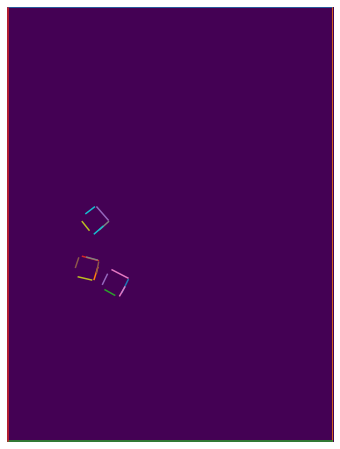

In [272]:
# Line finding using the Probabilistic Hough Transform
image_gray = rgb2gray(img_quant)*255**3/2
edgesHT = canny(image_gray, 2, 1, 25)
linesHT1 = probabilistic_hough_line(edgesHT, threshold=10, line_length=30,
                                 line_gap=3)

print(len(linesHT1))
plt.figure(figsize = (6,8))
plt.imshow(edgesHT * 0)
for line in linesHT1:
    p0, p1 = line
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]))
plt.axis('off')
plt.show()

In [273]:
def dist_puntos(p0,p1):
    return np.sqrt((p1[1]-p0[1])**2+(p1[0]-p0[0])**2)
def delete_long(linesdl):
    newlinesdl = []
    for linedl in linesdl:
        p0dl, p1dl = linedl
        len = dist_puntos(p0dl,p1dl)
        if len < SIZE[1]/2:
            newlinesdl.append(linedl)
            print(len)
    return newlinesdl

linesHT2 = delete_long(linesHT1)

60.959002616512684
34.785054261852174
63.06346010171025
41.773197148410844
48.27007354458868
37.8021163428716
50.08991914547278
43.965895873961216
38.948684188300895
57.97413216254298
38.91015291668744
37.656340767525464
35.84689665786984
38.3275357934736
38.41874542459709
39.698866482558415


In [274]:
def lineas2puntos(lineas):
    puntos = []
    for i in lineas:
        puntos.append(i[0])
        puntos.append(i[1])
    return puntos

puntosHT = lineas2puntos(linesHT2)
print(puntosHT)
        

[(358, 756), (318, 710), (242, 924), (253, 891), (428, 962), (372, 933), (328, 790), (359, 762), (299, 969), (252, 958), (279, 733), (309, 710), (407, 1013), (429, 968), (308, 967), (321, 925), (381, 1023), (347, 1004), (323, 900), (267, 885), (338, 984), (355, 949), (317, 943), (324, 906), (399, 1025), (417, 994), (319, 898), (282, 888), (290, 792), (266, 762), (309, 805), (339, 779)]


[[387.3        985.5       ]
 [315.5        759.9       ]
 [292.25       921.16666667]]


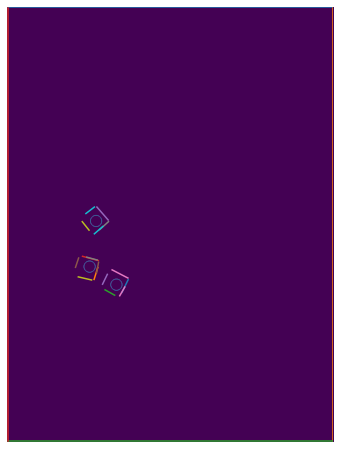

In [275]:
#Transformacion corrdenada a color
def centroides_dados(puntos):
    image_array = puntos
    #image_array_sample = shuffle(image_array, random_state=0, n_samples=1_000)
    #kmeans = KMeans(n_clusters=3, random_state=0).fit(image_array_sample)
    kmeans = KMeans(n_clusters=3, random_state=0).fit(puntos)
    #labels = kmeans.predict(image_array)
    colores = kmeans.cluster_centers_
    return colores

ubic_dados = centroides_dados(puntosHT)
print(ubic_dados)


SEEDS=ubic_dados

plt.figure(figsize = (6,8))
seeds_img = np.zeros((SIZE[0],SIZE[1]), dtype=np.uint32)
for seed in SEEDS:
    rr, cc = circle_perimeter(np.uint16(seed[1]), np.uint16(seed[0]), 20)
    seeds_img[rr,cc] = 1


plt.imshow(edgesHT * 0)
for line in linesHT1:
    p0, p1 = line
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]))
plt.imshow(seeds_img)
plt.axis('off')
plt.show()

In [276]:
"""
def dist_puntos(p0,p1):
    return np.sqrt((p1[1]-p0[1])**2+(p1[0]-p0[0])**2)
def delete_long(linesdl):
    newlinesdl = []
    for linedl in linesdl:
        p0dl, p1dl = linedl
        len = dist_puntos(p0dl,p1dl)
        if len < SIZE[1]/2:
            newlinesdl.append(linedl)
            print(len)
    return newlinesdl

linesHT2 = delete_long(linesHT1)
def m(linem):
    p0m, p1m = linem
    mm = (p1m[1]-p0m[1])/(p1m[0]-p0m[0])
    return mm
def theta_segm(linets):
    thetats = np.arctan2(-1,m(linets))
    return thetats
def rho_segm(liners):
    p0rs, p1rs = liners
    rhors = p0rs[0]*np.cos(theta_segm(liners)) + p0rs[1]*np.sin(theta_segm(liners))
    return rhors
def bool_equal_lines(line1be,line2be):
    #print(np.abs(rho_segm(line1be)-rho_segm(line2be)))
    #print(np.abs(theta_segm(line1be)-theta_segm(line2be)))
    if np.abs(rho_segm(line1be)-rho_segm(line2be)) < MAX_RHO and np.abs(theta_segm(line1be)-theta_segm(line2be)) < MAX_THETA:
        return True
    else:
        return False
plt.figure(figsize = (6,8))
plt.imshow(edgesHT * 0)
l1=linesHT2[0]
l2=linesHT2[1]
p0, p1 = l1
plt.plot((p0[0], p1[0]), (p0[1], p1[1]))
p0, p1 = l2
plt.plot((p0[0], p1[0]), (p0[1], p1[1]))
plt.axis('off')
plt.show()
print(bool_equal_lines(l1,l2))
def merge_lines(line1ml,line2ml):
    p00 = min(line1ml[0][0], line2ml[0][0], line1ml[1][0], line2ml[1][0])
    p01 = min(line1ml[0][1], line2ml[0][1], line1ml[1][1], line2ml[1][1])
    p10 = max(line1ml[0][0], line2ml[0][0], line1ml[1][0], line2ml[1][0])
    p11 = max(line1ml[0][1], line2ml[0][1], line1ml[1][1], line2ml[1][1])
    nl = ((p00,p01),(p10,p11))
    return nl
linesHT2
def clean12(linesc12):
    lines_res=[]
    x =[]
    for i in range(len(linesc12)):
        unique_line = True
        if i not in x:
            for k in range(i+1,len(linesc12)):
                if bool_equal_lines(linesc12[i],linesc12[k]):
                    #print(linesc12[i])
                    #print(linesc12[k])
                    unique_line=False
                    temp = linesc12[i]
                    #temp = merge_lines(linesc12[i],linesc12[k])
                    lines_res.append(temp)
                    x.append(k)
                    break
            if unique_line:
                #print(i)
                #print(linesc12[i])
                lines_res.append(linesc12[i])
    return lines_res

linesHT3 = clean12(linesHT2)
print(len(linesHT3))

plt.figure(figsize = (6,8))
plt.imshow(edgesHT * 0)
for line in linesHT3:
    p0, p1 = line
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]))
plt.axis('off')
plt.show()
"""


"\ndef dist_puntos(p0,p1):\n    return np.sqrt((p1[1]-p0[1])**2+(p1[0]-p0[0])**2)\ndef delete_long(linesdl):\n    newlinesdl = []\n    for linedl in linesdl:\n        p0dl, p1dl = linedl\n        len = dist_puntos(p0dl,p1dl)\n        if len < SIZE[1]/2:\n            newlinesdl.append(linedl)\n            print(len)\n    return newlinesdl\n\nlinesHT2 = delete_long(linesHT1)\ndef m(linem):\n    p0m, p1m = linem\n    mm = (p1m[1]-p0m[1])/(p1m[0]-p0m[0])\n    return mm\ndef theta_segm(linets):\n    thetats = np.arctan2(-1,m(linets))\n    return thetats\ndef rho_segm(liners):\n    p0rs, p1rs = liners\n    rhors = p0rs[0]*np.cos(theta_segm(liners)) + p0rs[1]*np.sin(theta_segm(liners))\n    return rhors\ndef bool_equal_lines(line1be,line2be):\n    #print(np.abs(rho_segm(line1be)-rho_segm(line2be)))\n    #print(np.abs(theta_segm(line1be)-theta_segm(line2be)))\n    if np.abs(rho_segm(line1be)-rho_segm(line2be)) < MAX_RHO and np.abs(theta_segm(line1be)-theta_segm(line2be)) < MAX_THETA:\n        